# Case 3 @ Trell

2021-09-11
Oscar Lundberg

lundberg.oscar@gmail.com

I am here presenting the Case 3. Some notes about my work in those Notebook.

* I have only made a brief outline in terms of the programming/data analysis. Instead of spending time on doing a full thorough work on this (as this would require way more than 2-4 hours), I have done a brief outline on the work, and then I try to convey my skills/way of reasoning by discussing on how I would proceed in this work (I hope this is ok).
    * In Section 6, I present a summary on how I would have been improving upon this work.
* Usually when I write Notebooks, I find myself usually putting code relating to my own methods/classes outside the Notebook.
    * The Notebook in my opinion should focus on the data and the storytelling, unless the code itself is the purpose of the Notebook (of course one can hide the code in the Notebook).
    * Having the code in a more dev-style project form, facilitates the testing in a more dev-style fashion, and also, if code is written for use in larger frameworks later on, that is facilitated.

## 1. Introduction

The purpose with this work is to create a model that is able to predict the heat consumption for 24+ hour in order to better plan distribution in order to avoid shortages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

from lib.ts_fft import ts_fft  # Method by OL

## 2. Loading the data
This section loads the data and presents the dataframe in a brief format.

The task is to predict the heat consumption for the first week of February 2019.
Thus I slice the data, and only use the data up do that date for modelling, 
in order to not have data leakage from that week into the model.

In [42]:
filename = "data/Case option 3 - Data.csv"  # File to be parsed
df = pd.read_csv(filename, parse_dates=["tstamp"], dayfirst=True)  # Parse the correct date format
df = df.set_index("tstamp")  # Use datetime as index
print(f"Number of NAs in the df {df.isnull().sum().sum()}")
df = df.dropna()
df_train = df[:"2019-01-31"]
df_test = df["2019-01-31":]
print(f"Number of rows in train dataframe: {len(df_train)}")
print(f"Number of rows in test dataframe: {len(df_test)}")
print(df_train.dtypes)
print(df_train.isnull().values.any())
print(df.isnull().sum().sum())
df_train.head()

Number of NAs in the df 2412
Number of rows in train dataframe: 61756
Number of rows in test dataframe: 2902
consumed_heat            float64
temp                     float64
cloud                    float64
day_of_week               object
holiday_in_general       float64
school_holiday_period    float64
public_holiday_period    float64
wind_direction           float64
wind_speed               float64
dtype: object
False
0


,consumed_heat,temp,cloud,day_of_week,holiday_in_general,school_holiday_period,public_holiday_period,wind_direction,wind_speed
tstamp,,,,,,,,,
2012-01-01 00:00:00,21.441080,-8.8,13.0,Sunday,1.0,1.0,1.0,0.0,0.0
2012-01-01 01:00:00,21.636080,-8.5,13.0,Sunday,1.0,1.0,1.0,0.0,0.0
2012-01-01 02:00:00,21.195580,-8.8,13.0,Sunday,1.0,1.0,1.0,130.0,1.0
2012-01-01 03:00:00,20.775913,-8.2,13.0,Sunday,1.0,1.0,1.0,130.0,1.0
2012-01-01 04:00:00,20.453913,-6.7,13.0,Sunday,1.0,1.0,1.0,110.0,1.0


## 3. EDA
In this section the data is presented.
Here we are trying to gain an understanding on how the data looks.
First we present the full series.

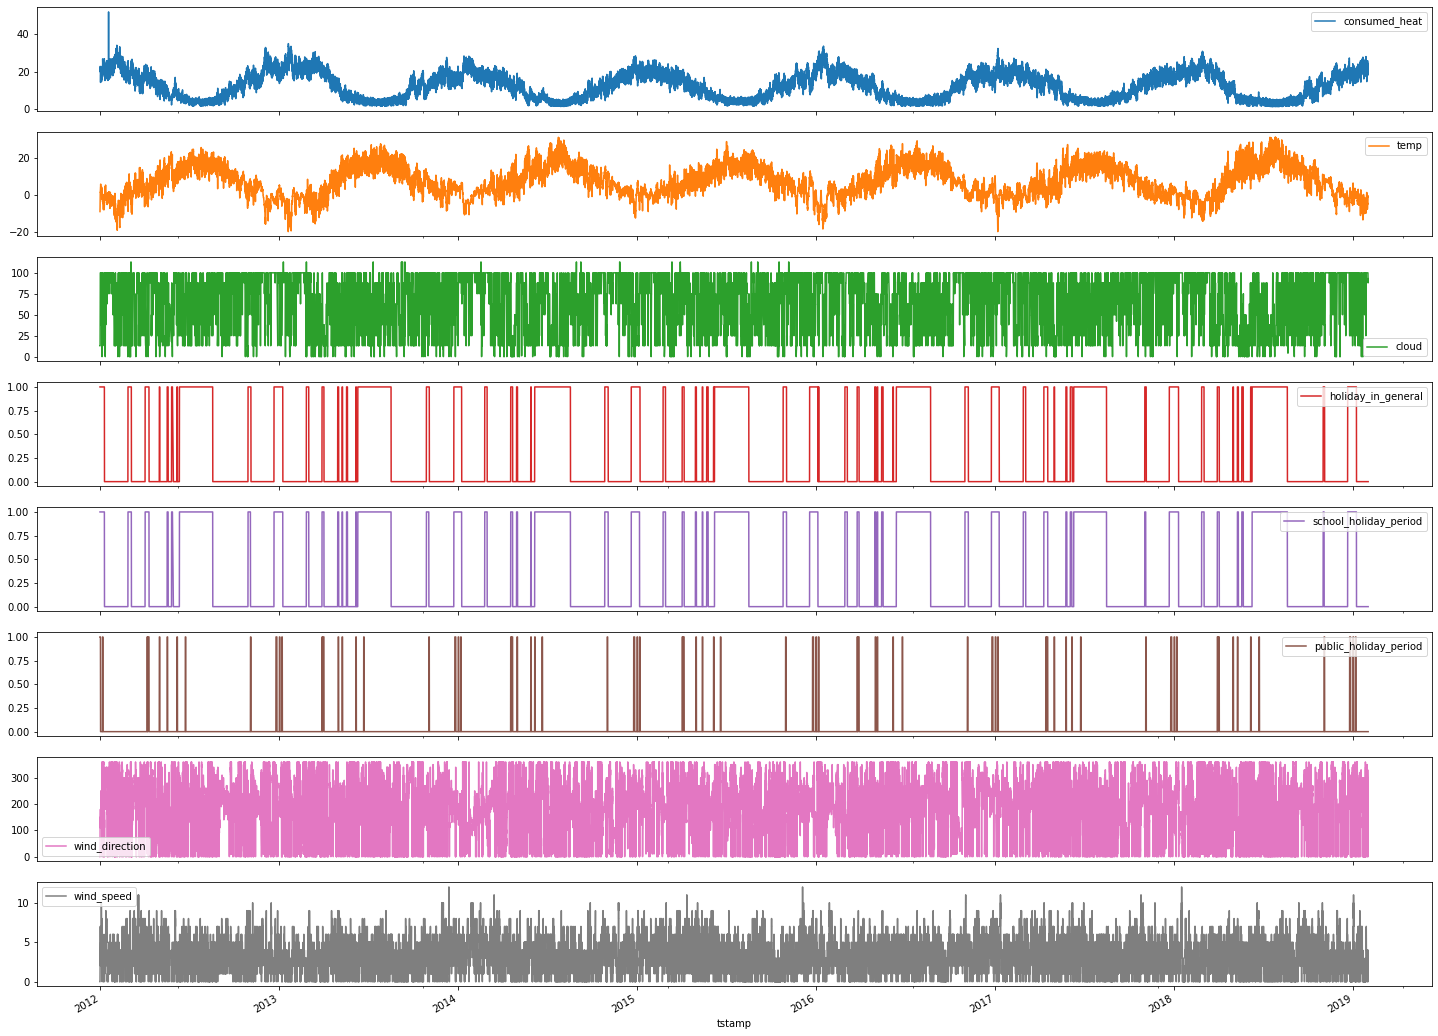

In [3]:
df_train.plot(figsize=(25, 20), subplots=True);  # Plot the full series

Here we present a shorter period of the data in order to have a brief view at a smaller time scale.

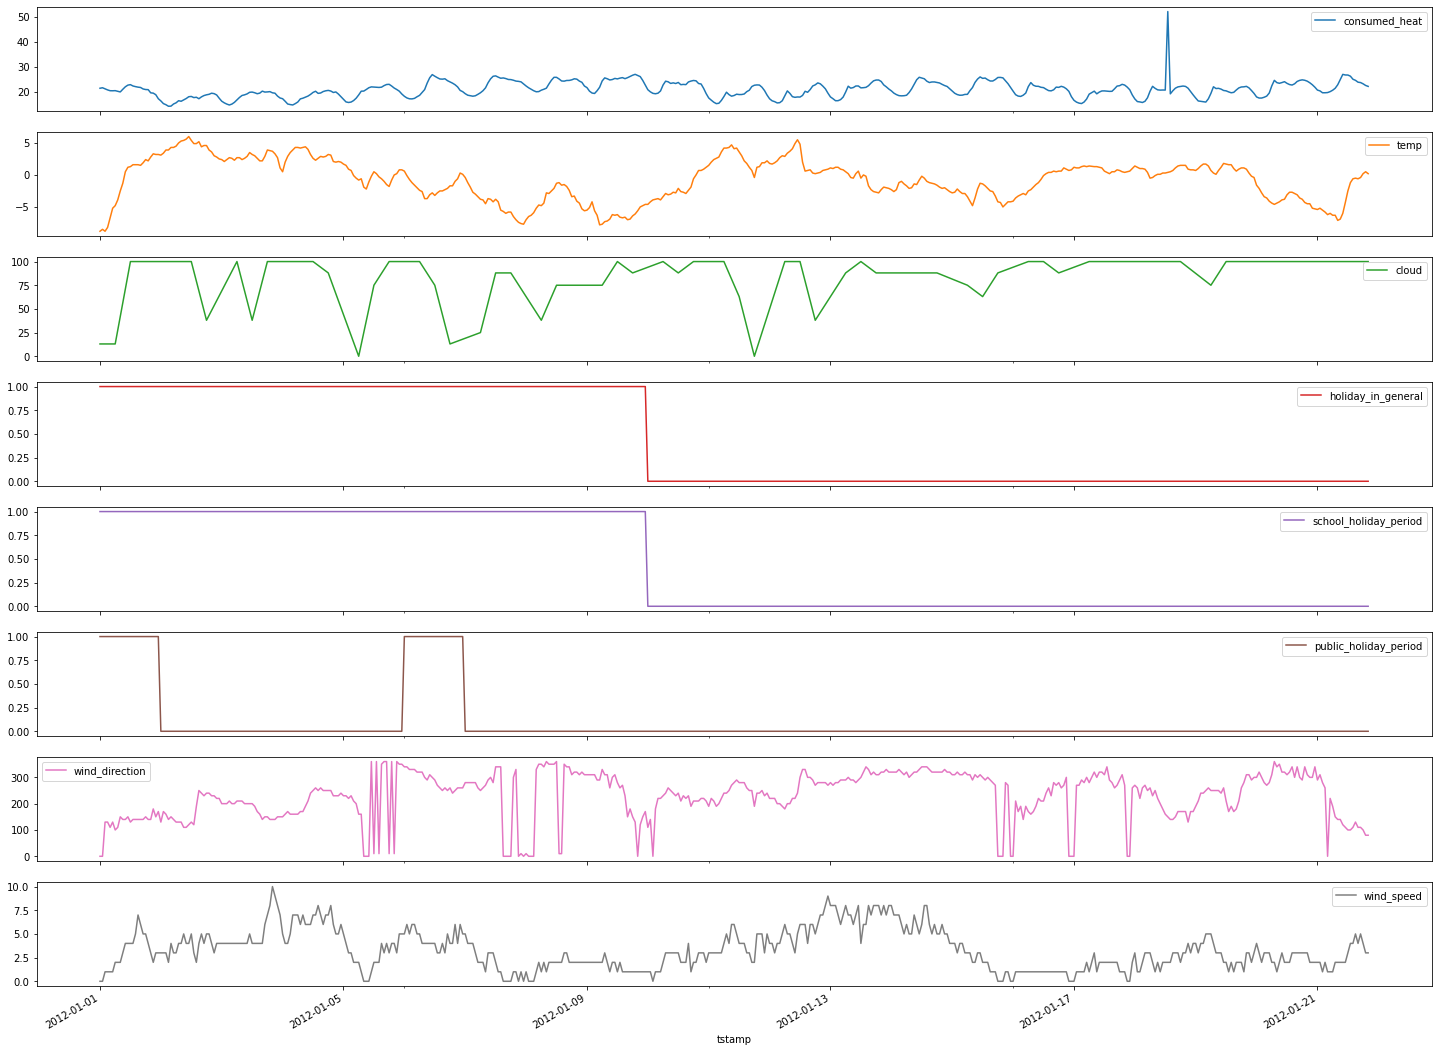

In [4]:
df_train[:500].plot(figsize=(25, 20), subplots=True);  

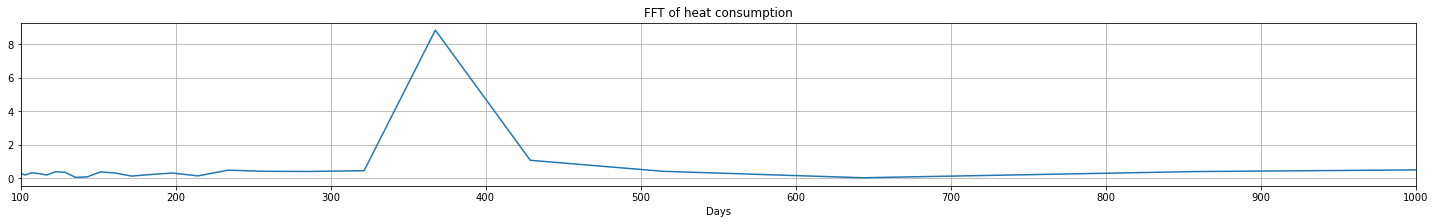

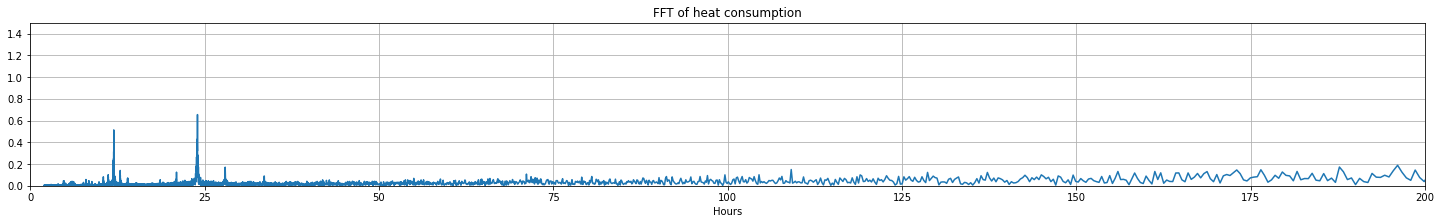

In [40]:
signal = df_train[["consumed_heat"]].to_numpy().flatten()
consumed_heat_fft, freq = ts_fft(signal, 1)  # 1 h sample rate
plt.figure(figsize=(25, 3))
plt.plot(1/freq[1:]/24, consumed_heat_fft[1:])
plt.title("FFT of heat consumption")
plt.xlabel("Days")
plt.xlim(left=100, right=1000)
plt.grid()
plt.figure(figsize=(25, 3))

plt.plot(1/freq[1:], consumed_heat_fft[1:])
plt.xlabel("Hours")
plt.title("FFT of heat consumption")
plt.ylim(bottom=0, top=1.5)
plt.xlim(left=0, right=200)
plt.grid()

### Observations

Some observations are made in the data.

* There is correlation between public holidays, general holidays. Thus those variables are not entirelly independent, which may be relevant for the modelling part.
* There is negative correlation (seasonal pattern) between the temperature and the heat consumption (365 days period).
* We note another seasonal pattern (day) (24 hour periods).
* We also have some binary variables (holidays).

## 3. Feature engineering
In this section, we will engineer (transform, scale, ...) the features for the modelling part.

Due to the seasonal pattern, we create some features involving which month, which day in month, and which weekday number (Monday=1, Sunday=7).

In [44]:
df_train_feat = df_train.copy()
df_test_feat = df_test.copy()

# Extract month, day in month, day of week
df_train_feat["month"] = df_train.index.month
df_train_feat["day_in_month"] = df_train.index.day
df_train_feat["day_of_week"] = df_train.index.dayofweek+1  # Let Monday=1 and Sunday=7


df_test_feat["month"] = df_test.index.month
df_test_feat["day_in_month"] = df_test.index.day
df_test_feat["day_of_week"] = df_test.index.dayofweek+1  # Let Monday=1 and Sunday=7

print(df_train_feat.dtypes)
df_train_feat.head()

consumed_heat            float64
temp                     float64
cloud                    float64
day_of_week                int64
holiday_in_general       float64
school_holiday_period    float64
public_holiday_period    float64
wind_direction           float64
wind_speed               float64
month                      int64
day_in_month               int64
dtype: object


,consumed_heat,temp,cloud,day_of_week,holiday_in_general,school_holiday_period,public_holiday_period,wind_direction,wind_speed,month,day_in_month
tstamp,,,,,,,,,,,
2012-01-01 00:00:00,21.441080,-8.8,13.0,7,1.0,1.0,1.0,0.0,0.0,1,1
2012-01-01 01:00:00,21.636080,-8.5,13.0,7,1.0,1.0,1.0,0.0,0.0,1,1
2012-01-01 02:00:00,21.195580,-8.8,13.0,7,1.0,1.0,1.0,130.0,1.0,1,1
2012-01-01 03:00:00,20.775913,-8.2,13.0,7,1.0,1.0,1.0,130.0,1.0,1,1
2012-01-01 04:00:00,20.453913,-6.7,13.0,7,1.0,1.0,1.0,110.0,1.0,1,1


## 4. Modelling

In this model we will only use a SARIMA model. 
Other models would have been possible to use (LSTM, CNN, ANN, ..).

The SARIMA is an extended ARIMA model which is able to include the Seaonal variations as well.
SARIMAX, where the X signifies that we have exogenous variables as well for the prediction.
I choose to only fit the model with the last 1000 hours, just for the sake of simplicity on fitting the model (saving time).
Note that I have left out the seasonal order pattern in this work.

In [27]:
exog = df_train.columns[1:]  # Exogenous variables
model = SARIMAX(df_train_feat["consumed_heat"][-1000:].to_numpy().astype(float), 
                exog=df_train_feat[exog][-1000:].to_numpy().astype(float),
                order=(48, 2, 2))
res = model.fit()

/home/oscar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/oscar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/oscar/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


## 5. Evaluation and Result

In this work I choose to predict the values for the full week ahead for simplicity (7 days*24 hours).
However, if the client only want a model that is able to predict 24 hours ahead, the approach of predicting 7 days ahead is imposing uneccesary complexity.
In order to have the best prediction only 24 hours ahead, a better way would be to have a rolling prediction 24 hours ahead, and make use of the fact that the exogenous variables actually are known to various degrees in advance, for the coming period.
I.e., since we know where coming holidays are, 
and that the temperature forecast the coming 24 hours probably is quite reliable (this may of course be argued), 
we may make use of them in order to predict the coming heat consumption.

Note that when we do the prediction, we use the first week of February 2019, which have not been included in the model fit (df_train/df_test).

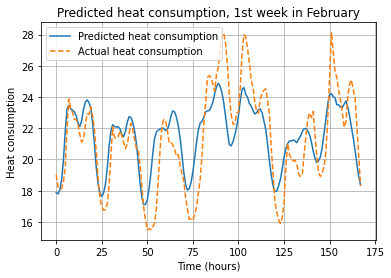

In [37]:
nforecast = 24*7  # 7 days ahead
predict = res.get_prediction(end=model.nobs + nforecast, 
                             exog=df_test_feat[exog][:nforecast+1].to_numpy().astype(float))

plt.figure()
plt.plot(predict.predicted_mean[-nforecast:], label="Predicted heat consumption")
plt.plot(df_test_feat["consumed_heat"][:nforecast].to_numpy(), linestyle='--', 
         label="Actual heat consumption")
plt.title("Predicted heat consumption, 1st week in February")
plt.xlabel("Time (hours)")
plt.ylabel("Heat consumption")
plt.legend()
plt.grid()
plt.savefig("prediction.png")
plt.show()

## 6. Discussion and Conclusion

In this work I have tried to convey how I would approach this problem. 
For each section, I here is summary how I would improve the work in order to create more value from the analysis.

* Section 1: Introduction
    * For the unintroduced reader, I would write a more thorough descirption on the outline on the analysis, and what the outcome of the analysis is.
* Section 2: Loading the Data
    * A more thorough analysis on the amount if NAs in the data.
        * This would help in order to better understand the data
        * Serve the purpose of providing feedback to the data engineer team, in order to understand why we have NAs, and also be able to improve the quality on the data.
* Section 3: EDA
    * A more throughough EDA on how the data looks.
        * Understanding on the data would probably bring value to the client directly (without considering the modelling part).
        * Understanding the data would help creating a better model.
* Section 4: Feature engineering
    * More thorough feature engineering, maybe there are other features we can create/consider.
* Section 5: Modelling
    * Consider other models.
    * A more thorough and motivated procedure for the SARIMA parameters. In this work I didn't consider this too much.
* Section 6: Evaluation and results
    * A more throughough testing of the model in various situations.
    * More metrics in order to better understand how the model is performing.
    * Given that we use the (S)ARIMA model, we may get insights from the actual model part on which data that is most correlated for the dependent variable (heat consumption). Some other models (neural networks etc.) may provide a more black box type of modeling, where it is harder to draw conclusions from the model itself.
* Section 7: Discussion and Conclusion
    * The work may bring value to the client in three ways.
        1) Delivering the performant model itself.
        2) Insight in the data, that brings value by having a better understanding on how the data looks (which parameters are more correlated to the outcome etc).
        3) Proposals/feedback on how to continue the work in order to create even more value from the analysis/modeling.

I am looking forward to receive feedback from Trell together with a nice discussion, what did you like, and what did you not like? / Oscar